In [1]:
import tadasets, ripser, persim
import matplotlib.pyplot as plt
import numpy as np
from greedy_sketch import naive_greedy_sketch, viz
from IPython.display import HTML

# Persistent Homology
### Rationale
Sometimes, a set of points has an underlying topology that might be obvious to a human, but it's tough to describe rigorously. Point sets like these often appear in real-world scenarios, so if we can describe them topologically, we can often learn more about them. This is one of the goals of **persistent homology**: to take a discrete set of points and allow them to be interpreted topologically.

### Idea
In very simple words, the idea of persistent homology is to take a point set and imagine slowly inflating a ball around each point. As they inflate, some balls will intersect. When a set of balls intersects such that form a loop, we say that a feature was **born**. Eventually, as the balls keep inflating, the space in the middle of the loop will get smaller and smaller, until it disappears and the feature **dies**.

### Persistence diagrams
To keep track of all the births and deaths, we use a **persistence diagram** (PD). Informally, every time a feature completes its life cycle of birth and death, we plot the point $(b, d)$ on the PD, where $b$ is the diameter of the balls when the feature was born, and $d$ is the diameter of the balls when the feature died. The points near the line $y = x$ represent features that died soon after they were born, and therefore probably aren't very representative of the topology of the original point set.

### Visualization
The following animation shows a $1^{st}$-homology PD being built as the balls around the points of a two-dimensional point set are inflated.

In [2]:
points = tadasets.dsphere(n=50, d=1, r=100, noise=15)
anim = viz.make_persistent_homology_animation(points)
HTML(anim.to_jshtml())

# The Metric Space of Persistence Diagrams

Instead of Euclidean distance (the $L^2$ norm), the distance between two points on a PD is computed using the $L^\infty$ norm,

$$ d_\infty(a, b) = \|a - b\|_\infty, \text{ where } \|x\|_\infty = \max_i{|x_i|}, $$

The distance between two points is the component of their difference with the largest magnitude.

The space of all possible PDs forms a natural metric space with the $\infty$-Wasserstein metric, $W_\infty$, as the distance function. The **bottleneck distance** between two PDs, $P$ and $Q$, is defined as:

$$ W_\infty(P, Q) = \inf_{\eta:P \rightarrow Q}\Big(\sup_{p \in P}{\operatorname{d}_\infty(p, \eta(p))}\Big), $$

Computing this distance involves doing the following:

(1) compute a **matching** (a bijective mapping), $\eta$, between elements of $P$ and $Q$

(2) the cost of one particular matching is the greatest distance of all the pairs of points mapped to each other in that matching

(3) the distance between $P$ and $Q$ is the cost of the matching which minimizes this greatest distance

To better understand this metric space, it is worth noting that it is a composition of two metric spaces: within a PD, we deal with points and the $L^\infty$ distance metric, while the bottleneck distance metric is used when comparing PDs themselves.

As one can imagine, computing the bottleneck distance is not easy. Even the best algorithms today run in time $O(n^2 \log n)$.

(2000, 3)


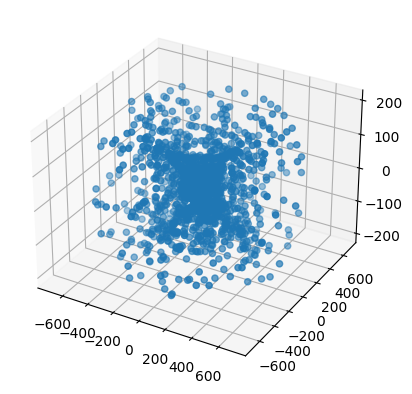

In [3]:
# Generate a 2000-point three-dimensional point set
points = np.empty((0,3))
c = [11,25,50,75,100,200,250,300,400,500]
a = [5,10,25,50,75,100,125,150,175,200]
for c, a in zip(c, a):
    points = np.append(points, tadasets.torus(n=200, c=c, a=a), axis=0)

ax = plt.axes(projection='3d')
ax.scatter(points.T[0], points.T[1], points.T[2])
print(points.shape)

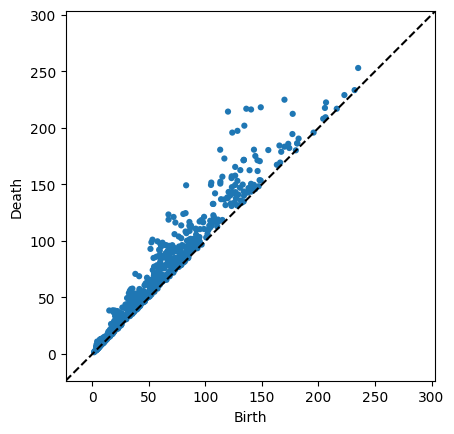

In [4]:
# Find its persistence diagram
rips = ripser.ripser(points)
persim.plot_diagrams(rips['dgms'][1], show=True, legend=False)

# Greedy Sketches
### Rationale
The set of points in a PD can get huge. And most of these points could be really close to the diagonal which does not convey any meaningful information about the underlying set. Instead, we can use an approximation of the PD, called a **greedy sketch**.

### Idea
The goal of a greedy sketch is to make an approximation of the original PD with a good subset of its original points. To choose this subset, we use a [greedy permutation](https://www.youtube.com/watch?v=xWuq1aXHLdU). Given a set of points, $X$, the greedy ordering, $P_X$, starts off by selecting an arbitrary initial point and keeps adding points to $P_X$ by selecting the point in $X$ furthest away from the points already in $P_X$.

### Greedy Permutation Applied to Persistence Diagrams
So, given a PD, $D$, with $n$ points, a greedy sketch of $D$, $D_i$, would contain $i$ points of $D$ selected by greedy ordering. By geometric properties of the greedy permutation, $D_i$ is a $2$-approximation of the optimal $i$-point PD closest to $D$. Points of the PD that are not present in the greedy sketch are mapped to their reverse nearest neighbor in the sketch. Thus, every point in the sketch has multiplicity or mass.

As new points are added over successive sketches it is possible that a new point in a sketch is closer to some points in the PD than a point already existing in the sketch. So, there is a movement of mass to a newly added point from its neighbors in the sketch. This mass movement over successive sketches is captured in a transportation plan.

Using just the greedy set of points and the transportation plans we get a useful approximation of the PD. The time taken to compute this approximation is theoretically $O(n \log\Delta)$ where $\Delta$ is the spread, or the ratio of greatest to smallest pairwise distances, of $D$. Our implementation runs in $O(n^2)$ and all sketches are stored in space $O(n)$.

### Bottleneck Distance between $D$ and $D_i$
With increasing $i$, the bottleneck distance between a sketch and the original PD goes on decreasing and tends to $0$ as $i$ approaches $n$. So, we keep getting a closer and closer approximation of the original PD with each iteration.

### Visualization
The following animation shows consecutive greedy sketches being built. When a point is added to the greedy sketch, its reverse nearest neighbors are colored to show its multiplicity. The bottleneck distance between the current and next greedy stch is shown as a solid line.


In [5]:
anim = viz.make_greedy_sketch_animation(naive_greedy_sketch(rips['dgms'][1], n=15, minimal=False))
HTML(anim.to_jshtml())